# Representation with a Feature Cross

## 0/ Import relevant modules

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

tf.keras.backend.set_floatx('float32')


## 1/ Load, scale, and shuffle the examples

In [2]:
# Load the dataset
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# Scale the labels
scale_factor = 1000.0
# Scale the training set's label.
train_df["median_house_value"] /= scale_factor 

# Scale the test set's label
test_df["median_house_value"] /= scale_factor

# Shuffle the examples
train_df = train_df.reindex(np.random.permutation(train_df.index))

## 2/ Define functions that create and train a model, and a plotting function

In [6]:
def create_model(my_learning_rate, feature_layer):
    """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
    model.add(feature_layer)

  # Add one linear layer to the model to yield a simple linear regressor.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

  # Construct the layers into a model that TensorFlow can execute.
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model           


def train_model(model, dataset, epochs, batch_size, label_name):
    """Feed a dataset into the model in order to train it."""

    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name))
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)

  # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch
  
  # Isolate the mean absolute error for each epoch.
    hist = pd.DataFrame(history.history)
    rmse = hist["root_mean_squared_error"]

    return epochs, rmse   


def plot_the_loss_curve(epochs, rmse):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")

    plt.plot(epochs, rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
    plt.show()  

## 3/ Floating-point

### 3.1/Represent latitude and longitude as floating-point values 

In [3]:
# Create an empty list that will eventually hold all feature columns.
feature_columns = []

# Create a numerical feature column to represent latitude.
latitude = tf.feature_column.numeric_column("latitude")
feature_columns.append(latitude)

# Create a numerical feature column to represent longitude.
longitude = tf.feature_column.numeric_column("longitude")
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
fp_feature_layer = layers.DenseFeatures(feature_columns)

### 3.2/ Train the model with floating-point representations

2022-08-06 01:04:07.664639: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/30
170/170 [==============================] - 1s 3ms/step - loss: 13557.2041 - root_mean_squared_error: 116.4354
Epoch 2/30
170/170 [==============================] - 1s 3ms/step - loss: 13472.8066 - root_mean_squared_error: 116.0724
Epoch 3/30
170/170 [==============================] - 0s 3ms/step - loss: 13433.1338 - root_mean_squared_error: 115.9014
Epoch 4/30
170/170 [==============================] - 0s 2ms/step - loss: 13371.5371 - root_mean_squared_error: 115.6354
Epoch 5/30
170/170 [==============================] - 0s 2ms/step - loss: 13324.5098 - root_mean_squared_error: 115.4318
Epoch 6/30
170/170 [==============================] - 0s 2ms/step - loss: 13289.3643 - root_mean_squared_error: 115.2795
Epoch 7/30
170/170 [==============================] - 0s 2ms/step - loss: 13260.5264 - root_mean_squared_error: 115.1544
Epoch 8/30
170/170 [==============================] - 0s 3ms/step - loss: 13217.4297 - root_mean_squared_error: 114.9671
Epoch 9/30
170/170 [============

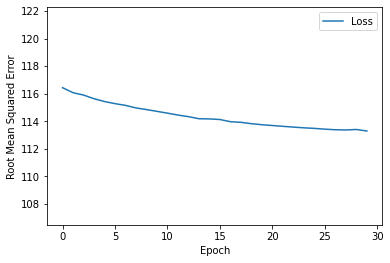


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 12167.7070 - root_mean_squared_error: 110.3073


[12167.70703125, 110.30732727050781]

In [7]:
# The following variables are the hyperparameters.
learning_rate = 0.05
epochs = 30
batch_size = 100
label_name = 'median_house_value'

# Create and compile the model's topography.
my_model = create_model(learning_rate, fp_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## 4/ Bucket

### 4.1/ Represent latitude and longitude in buckets

The model will learn a separate weight for each bucket. For example, the model will learn one weight for all the neighborhoods in the "35" bin, a different weight for neighborhoods in the "36" bin, and so on. This representation will create approximately 20 buckets:

  * 11 buckets for `latitude`: `(-Inf, 32)`, `[32, 33)`, ..., `[40, 41)`, `[41, +Inf)`
   ```python 
    latitude_boundaries = [32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
   ```
  * 12 buckets for `longitude`: `(-Inf, -124)`, `[-124, -123)`, ..., `[-115, -114)`, `[-114, +Inf)`
   ```python
    longitude_boundaries = [-124, -123, -122, -121, -120, -119, -118, -117, -116, -115, -114]
   ```

In [19]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])) + resolution_in_degrees, 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])) + resolution_in_degrees, 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Convert the list of feature columns into a layer that will ultimately become
# part of the model. Understanding layers is not important right now.
buckets_feature_layer = layers.DenseFeatures(feature_columns)

### 4.2/ Train the model with bucket representations

Epoch 1/35


/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 3ms/step - loss: 52135.2617 - root_mean_squared_error: 228.3315
Epoch 2/35
170/170 [==============================] - 0s 2ms/step - loss: 44734.8320 - root_mean_squared_error: 211.5061
Epoch 3/35
170/170 [==============================] - 0s 3ms/step - loss: 38138.4336 - root_mean_squared_error: 195.2906
Epoch 4/35
170/170 [==============================] - 0s 3ms/step - loss: 32343.4609 - root_mean_squared_error: 179.8429
Epoch 5/35
170/170 [==============================] - 1s 3ms/step - loss: 27312.8750 - root_mean_squared_error: 165.2661
Epoch 6/35
170/170 [==============================] - 0s 2ms/step - loss: 23038.4062 - root_mean_squared_error: 151.7841
Epoch 7/35
170/170 [==============================] - 0s 2ms/step - loss: 19520.1816 - root_mean_squared_error: 139.7146
Epoch 8/35
170/170 [==============================] - 0s 2ms/step - loss: 16707.4258 - root_mean_squared_error: 129.2572
Epoch 9/35
170/170 [=======================

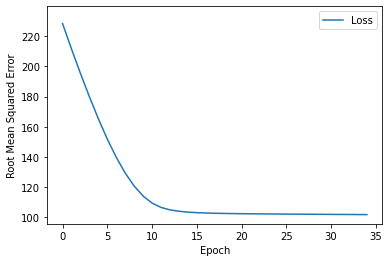


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 10208.2852 - root_mean_squared_error: 101.0361


[10208.28515625, 101.03605651855469]

In [20]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the buckets_feature_layer.
my_model = create_model(learning_rate, buckets_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

## 5/ Feature cross

### 5.1/ Represent location as a feature cross

In [26]:
resolution_in_degrees = 1.0 

# Create a new empty list that will eventually hold the generated feature column.
feature_columns = []

# Create a bucket feature column for latitude.
latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude")
latitude_boundaries = list(np.arange(int(min(train_df['latitude'])), 
                                     int(max(train_df['latitude'])) + resolution_in_degrees, 
                                     resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_as_a_numeric_column, 
                                               latitude_boundaries)
feature_columns.append(latitude)

# Create a bucket feature column for longitude.
longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude")
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])), 
                                      int(max(train_df['longitude'])) + resolution_in_degrees, 
                                      resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_as_a_numeric_column, 
                                                longitude_boundaries)
feature_columns.append(longitude)

# Create a feature cross of latitude and longitude.
latitude_x_longitude = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(latitude_x_longitude)
feature_columns.append(crossed_feature)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_cross_feature_layer = layers.DenseFeatures(feature_columns)

# Train the model with feature cross representations
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)

### 5.2/ Train the model with feature cross representations

Epoch 1/35


/Users/nguyenhien/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


170/170 [==============================] - 1s 3ms/step - loss: 50800.5703 - root_mean_squared_error: 225.3898
Epoch 2/35
170/170 [==============================] - 0s 3ms/step - loss: 41437.9062 - root_mean_squared_error: 203.5630
Epoch 3/35
170/170 [==============================] - 0s 3ms/step - loss: 33464.7109 - root_mean_squared_error: 182.9336
Epoch 4/35
170/170 [==============================] - 0s 3ms/step - loss: 26781.5957 - root_mean_squared_error: 163.6508
Epoch 5/35
170/170 [==============================] - 0s 3ms/step - loss: 21419.2188 - root_mean_squared_error: 146.3531
Epoch 6/35
170/170 [==============================] - 1s 3ms/step - loss: 17284.1738 - root_mean_squared_error: 131.4693
Epoch 7/35
170/170 [==============================] - 1s 3ms/step - loss: 14245.2461 - root_mean_squared_error: 119.3534
Epoch 8/35
170/170 [==============================] - 1s 3ms/step - loss: 12158.0830 - root_mean_squared_error: 110.2637
Epoch 9/35
170/170 [=======================

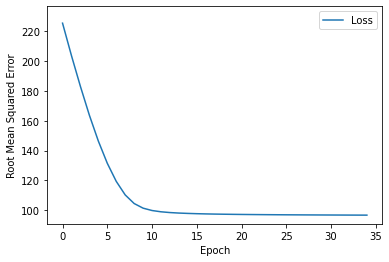


: Evaluate the new model against the test set:
30/30 [==============================] - 0s 2ms/step - loss: 9204.1807 - root_mean_squared_error: 95.9384


[9204.1806640625, 95.93842315673828]

In [27]:
# The following variables are the hyperparameters.
learning_rate = 0.04
epochs = 35

# Build the model, this time passing in the feature_cross_feature_layer: 
my_model = create_model(learning_rate, feature_cross_feature_layer)

# Train the model on the training set.
epochs, rmse = train_model(my_model, train_df, epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

print("\n: Evaluate the new model against the test set:")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)